In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from technicals import create_weekly_dataset, make_cycling_data, \
    train_test_split_each_route, pd, np, LabelEncoder, to_categorical, class_weight

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import shuffle

from sklearn.metrics import classification_report as CR, ConfusionMatrixDisplay

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Input

c:\Users\kubko\Documents\School\R_3\PRIDAV\PRIDAV-JPD\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Škálovanie a spájanie názvov

In [ ]:
cycling_data = make_cycling_data()
X, y = create_weekly_dataset(cycling_data)
X = MinMaxScaler().fit_transform(X)
X = X.reshape(-1, 2,168)

s = pd.Series(y) # alebo pôvodný stĺpec df['nazov']
print("Počty vzoriek pre lokality:")
print(s.value_counts().to_string())


Počty vzoriek pre lokality:
Cyklomost            594
Hradza               575
Viedenska            575
Devinska Nova Ves    320
Dolnozemská          171
River Park           171
Starý Most           171
Devínska cesta       148
Most SNP             147
Vajnorská            147
Páričkova            147
Dunajská             145
Železná studnička    145
Most Apollo          144
Vajanského            98
Einsteinova           44
Trenčianska           44


In [6]:
X_train, X_test, y_train, y_test = train_test_split_each_route(X, y, test_size=0.3)

In [7]:
print(len(np.unique(y_train)))
counts = {"Názov":[],"Počet":[], "Počet test":[]}
for y in y_train:
    if y in counts["Názov"]:
        i = counts["Názov"].index(y)
        counts["Počet"][i] += 1
    else:
        counts["Názov"].append(y)
        counts["Počet"].append(1)
        counts["Počet test"].append(0)
for y in y_test:
    if y in counts["Názov"]:
        i = counts["Názov"].index(y)
        counts["Počet test"][i] += 1
        
x = pd.DataFrame(counts)
x.sort_values("Počet",ascending=False)

17


,Názov,Počet,Počet test
0,Cyklomost,415,179
6,Hradza,402,173
15,Viedenska,402,173
1,Devinska Nova Ves,224,96
3,Dolnozemská,119,52
10,River Park,119,52
11,Starý Most,119,52
2,Devínska cesta,103,45
8,Most SNP,102,45
14,Vajnorská,102,45


Klasifikujeme tieto lokality: ['Cyklomost' 'Devinska Nova Ves' 'Devínska cesta' 'Dolnozemská' 'Dunajská'
 'Einsteinova' 'Hradza' 'Most Apollo' 'Most SNP' 'Páričkova' 'River Park'
 'Starý Most' 'Trenčianska' 'Vajanského' 'Vajnorská' 'Viedenska'
 'Železná studnička'] 17


In [16]:
models = {"not_weighted_classes": Sequential(), "weighted_classes": Sequential()}
for model in models.values():
    model.add(Input(shape=(2,168)))
    model.add(Bidirectional(LSTM(72, return_sequences=False)))
    model.add(Dropout(0.4))
    model.add(Dense(36, activation='relu'))
    model.add(Dense(len(class_names), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [17]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [18]:
history1 = models["not_weighted_classes"].fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1975 - loss: 2.6312 - val_accuracy: 0.2462 - val_loss: 2.3745
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2984 - loss: 2.1824 - val_accuracy: 0.4223 - val_loss: 1.8692
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3932 - loss: 1.8113 - val_accuracy: 0.4602 - val_loss: 1.6192
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4500 - loss: 1.5803 - val_accuracy: 0.5057 - val_loss: 1.4303
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5088 - loss: 1.3874 - val_accuracy: 0.5568 - val_loss: 1.2604
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5789 - loss: 1.2242 - val_accuracy: 0.6212 - val_loss: 1.1024
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6258 - loss: 1.0844 - val_accuracy: 0.6667 - val_loss: 0.9886
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6874 - loss: 0.9634 - val_accuracy: 0.7292 - val_loss

In [19]:
history2 = models["weighted_classes"].fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0734 - loss: 2.7364 - val_accuracy: 0.1004 - val_loss: 2.6057
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1772 - loss: 2.3668 - val_accuracy: 0.1875 - val_loss: 2.3529
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2885 - loss: 1.9780 - val_accuracy: 0.3447 - val_loss: 2.0174
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3899 - loss: 1.6780 - val_accuracy: 0.4451 - val_loss: 1.7145
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4458 - loss: 1.4320 - val_accuracy: 0.5322 - val_loss: 1.4696
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5130 - loss: 1.2293 - val_accuracy: 0.5606 - val_loss: 1.2874
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5339 - loss: 1.1003 - val_accuracy: 0.6061 - val_loss: 1.1642
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5793 - loss: 0.9832 - val_accuracy: 0.6023 - val_loss:

In [20]:
for name, model in models.items():
    print(f"\nVyhodnotenie modelu: {name}")
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"\nPresnosť na testovacích dátach: {accuracy*100:.2f}%")


Vyhodnotenie modelu: not_weighted_classes
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7602 - loss: 1.9295

Presnosť na testovacích dátach: 76.02%

Vyhodnotenie modelu: weighted_classes
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7097 - loss: 2.1101

Presnosť na testovacích dátach: 70.97%


In [26]:
for name, model in models.items():
    print(f"\nUkážka predikcie modelu: {name}")
    idx = 7
    pred_prob = model.predict(X_test[idx:idx+1])
    pred_label = class_names[np.argmax(pred_prob)]
    true_label = class_names[np.argmax(y_test[idx])]

    print(f"\nTest vzorka č.{idx}:")
    print(f"Realita:   {true_label}")
    print(f"Predikcia: {pred_label}")


Ukážka predikcie modelu: not_weighted_classes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Test vzorka č.7:
Realita:   Cyklomost
Predikcia: Cyklomost

Ukážka predikcie modelu: weighted_classes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Test vzorka č.7:
Realita:   Cyklomost
Predikcia: Cyklomost



Matica zámien pre model: not_weighted_classes
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


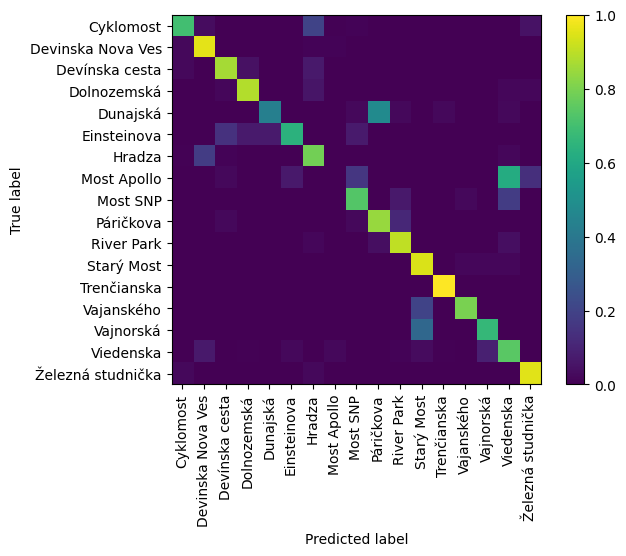


Matica zámien pre model: weighted_classes
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


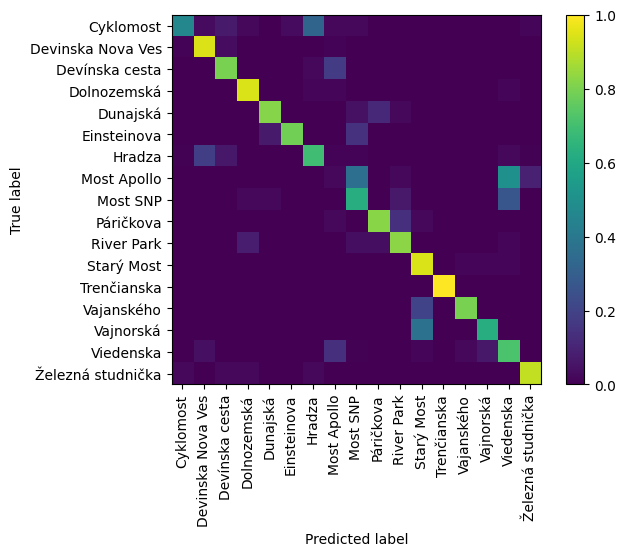

In [27]:
for name, model in models.items():
    print(f"\nMatica zámien pre model: {name}")
    ConfusionMatrixDisplay.from_predictions(
        np.argmax(y_test, axis=1),
        np.argmax(model.predict(X_test), axis=1),
        display_labels=class_names,
        cmap='viridis',
        xticks_rotation=90,
        normalize='true',
        include_values=False,
    )
    plt.show()

In [33]:
# Count misclassifications, then count double (second best prediction is correct), or third
y_pred_probs = models["weighted_classes"].predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
errors = np.where(y_pred_classes != y_true_classes)[0]
print(f"\nPočet nesprávnych klasifikácií: {len(errors)}")
errors2 = np.where(np.argsort(y_pred_probs, axis=1)[:,-2][errors] == y_true_classes[errors])[0]
print(f"Počet klasifikácii, kde druhá najpravdepodobnejšia predikcia je správna: {len(errors2)}")
errors3 = np.where(np.argsort(y_pred_probs, axis=1)[:,-3][errors] == y_true_classes[errors])[0]
print(f"Počet klasifikácii, kde tretia najpravdepodobnejšia predikcia je správna: {len(errors3)}")


print("\nDetailná klasifikačná správa:")
print(CR(y_true_classes, y_pred_classes, target_names=class_names))

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Počet nesprávnych klasifikácií: 333
Počet klasifikácii, kde druhá najpravdepodobnejšia predikcia je správna: 141
Počet klasifikácii, kde tretia najpravdepodobnejšia predikcia je správna: 75

Detailná klasifikačná správa:
                   precision    recall  f1-score   support

        Cyklomost       0.97      0.46      0.63       179
Devinska Nova Ves       0.67      0.95      0.79        96
   Devínska cesta       0.56      0.80      0.66        45
      Dolnozemská       0.83      0.94      0.88        52
         Dunajská       0.95      0.82      0.88        44
      Einsteinova       0.69      0.79      0.73        14
           Hradza       0.66      0.69      0.68       173
      Most Apollo       0.02      0.02      0.02        44
         Most SNP       0.49      0.62      0.55        45
        Páričkova       0.84      0.82      0.83        45
       River Park       0.80      0.83      0.81        52
       Starý Most       0.64  